<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/tapi-logo-small.png" />

This notebook free for educational reuse under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/).

Created by [Firstname Lastname](https://) for the 2022 Text Analysis Pedagogy Institute, with support from the [National Endowment for the Humanities](https://neh.gov), [JSTOR Labs](https://labs.jstor.org/), and [University of Arizona Libraries](https://new.library.arizona.edu/).

For questions/comments/improvements, email author@email.address.<br />
____

# `NLP with spaCy` `3`

This is lesson `3` of 3 in the educational series on `Natural Language Processing (NLP)`. This notebook is intended `to teach the basics of NLP and the spaCy library.`. 

**Audience:** `Teachers` / `Learners` / `Researchers`

**Use case:** `Tutorial`

`Include the use case definition from [here](https://constellate.org/docs/documentation-categories)`

**Difficulty:** `Beginner`

`Beginner assumes users are relatively new to Python and Jupyter Notebooks. The user is helped step-by-step with lots of explanatory text.`

`Intermediate assumes users are familiar with Python and have been programming for 6+ months. Code makes up a larger part of the notebook and basic concepts related to Python are not explained.`

`Advanced assumes users are very familiar with Python and have been programming for years, but they may not be familiar with the process being explained.`

**Completion time:** `90 minutes`

**Knowledge Required:** 
```
* Python basics (variables, flow control, functions, lists, dictionaries)
```

**Knowledge Recommended:**
```
* Basic file operations (open, close, read, write)
```

**Learning Objectives:**
After this lesson, learners will be able to:
```
1. Understand how to solve an NLP problem, specifically information extraction
2. Understand how to find data
3. Understand how to structure data
4. Understand how to develop a spaCy Pipeline
```
**Research Pipeline:**
```
N/A
```
___

# Required Python Libraries
`List out any libraries used and what they are used for`
* [spaCy](https://spacy.io/) for performing [Natural Language Processing (NLP)](https://docs.constellate.org/key-terms/#nlp).

## Install Required Libraries

In [1]:
### Install Libraries ###

# Using !pip installs
!pip install spacy
!pip install https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl
# Using %%bash magic with apt-get and yes prompt

     ------------------------------------- 237.1/237.1 MB 16.8 MB/s eta 0:00:00


In [2]:
### Import Libraries ###
import spacy
from spacy import displacy

c:\Users\wma22\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\wma22\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\wma22\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\wma22\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Introduction


In this notebook, we will be working with Patrick Burns' LatinCy, a package for working with Latin in spaCy natively. In order to download and install the requirements for LatinCy, make sure to run the install cell above the Introduction header.

To get started, we will load our LatinCy pipeline with the following command.

In [3]:
nlp = spacy.load("la_core_web_lg")

Let's examine some of the pipes in the LatinCy pipeline.

In [17]:
nlp.pipe_names

['normer',
 'tok2vec',
 'tagger',
 'morphologizer',
 'trainable_lemmatizer',
 'parser',
 'lemma_fixer',
 'ner']

As we can see, we have a few things that are not standard to most spaCy pipelines. These are custom components. We specifically have a `normer` and a `lemma_fixer`. When creating custom spaCy pipelines, especially for languages other than English, it may be very important to construct custom components for resolving issues in a text or issues with the outputs of certain pipes at various stages of the pipeline.

Let's check out the code for these two components:

**Code for normer: https://huggingface.co/latincy/la_core_web_lg/blob/main/functions.py**
```python
@Language.component("normer")
def normer(doc):
    def norm(text):
        return (
            text.replace("v", "u").replace("j", "i").replace("V", "U").replace("J", "I")
        )

    for token in doc:
        token.norm_ = norm(token.norm_)
    return doc
```
Notice that the `normer`'s sole purpose is to normalize, or make standard, the different ways Latin may appear. This is how this pipeline expects to be sent to the different models. Rather than forcing users to normalize their data before sending it to the pipeline, LatinCy handles this for you. This is a feature of the CLTK with Latin texts that standardizes, or normalizes the uses of v and u and j and i, both letters of which are interchangeable in Latin, but whose uses are not standard across editions. To prevent models from having to learn greater complexity than necessary and to prevent inconsistencies in training, we often normalize texts in this way. It is important, however, to pass data to the models in the same format as the data that the model was trained on. The `normer` handles this.


**Code for lemma_fixer**

```python
@Language.component("lemma_fixer")
def lemma_fixer(doc):

    for token in doc:
        if token.text == "que" and (
            token.pos_ == "CCONJ" or token.tag_ == "conjunction"
        ):
            token.lemma_ = token.text
        if token.text in string.punctuation:
            token.lemma_ = token.text
            token.pos_ = "PUNCT"
            token.tag_ = "punc"
    return doc
```

We also have this `lemma_fixer` component. This component's purpose is to correct lemmas in specific instances, namely when `que` functions as a conjunction. Here, the lemma form is "que". The same occurs for all punctuations. If we were to disable these pipes, we would see different outputs, likely for the worse.

Here are a few other ways we can examine the pipeline.

In [26]:
nlp.pipeline

[('normer', <function la_core_web_lg.functions.normer(doc)>),
 ('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x234ce1843a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x234ce184520>),
 ('morphologizer',
  <spacy.pipeline.morphologizer.Morphologizer at 0x234ce184700>),
 ('trainable_lemmatizer',
  <spacy.pipeline.edit_tree_lemmatizer.EditTreeLemmatizer at 0x234ce184580>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x234ce173820>),
 ('lemma_fixer', <function la_core_web_lg.functions.lemma_fixer(doc)>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x234ce173900>)]

Notice that when we print off the component_names, we see an extra pipe, `senter`. Why is that? Let's find out.

In [31]:
nlp.component_names

['senter',
 'normer',
 'tok2vec',
 'tagger',
 'morphologizer',
 'trainable_lemmatizer',
 'parser',
 'lemma_fixer',
 'ner']

If we print off the disabled pipes, we can see that `senter` is disabled. It is, therefore, a component in the pipeline but not used by default.

In [32]:
nlp.disabled

['senter']

We can resolve this by activating the `senter` with `enable_pipe()`.

In [35]:
nlp.enable_pipe("senter")

And now, we can see a list of the pipe names is updated.

In [37]:
nlp.pipe_names

['senter',
 'normer',
 'tok2vec',
 'tagger',
 'morphologizer',
 'trainable_lemmatizer',
 'parser',
 'lemma_fixer',
 'ner']

In [42]:
nlp.analyze_pipes()

{'summary': {'senter': {'assigns': ['token.is_sent_start'],
   'requires': [],
   'scores': ['sents_f', 'sents_p', 'sents_r'],
   'retokenizes': False},
  'normer': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'morphologizer': {'assigns': ['token.morph', 'token.pos'],
   'requires': [],
   'scores': ['pos_acc', 'morph_acc', 'morph_per_feat'],
   'retokenizes': False},
  'trainable_lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False

# Applying LatinCy

Let's go ahead and now work with LatinCy in practice. Let's try and read in Livy Book 28 from The Latin Library. I have saved this for demonstration purposes in `data/livy.txt`. We can access it with the following code.

In [4]:
with open("../data/livy.txt", "r", encoding="utf-8") as f:
    text = f.read()
print(text[:500])

TITI LIVI AB VRBE CONDITA LIBER XXVIII

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46

[1] Cum transitu Hasdrubalis quantum in Italiam declinauerat belli tantum leuatae Hispaniae uiderentur, renatum ibi subito par priori bellum est. Hispanias ea tempestate sic habebant Romani Poenique: Hasdrubal Gisgonis filius ad Oceanum penitus Gadesque concesserat: nostri maris ora omnisque ferme Hispania qua in orientem uergit


As we can see, we need to clean up the text a bit, let's go ahead and grab the main body of the text.

In [5]:
body = text.split("\n\n", 2)[2].strip()
print(body[:500])

[1] Cum transitu Hasdrubalis quantum in Italiam declinauerat belli tantum leuatae Hispaniae uiderentur, renatum ibi subito par priori bellum est. Hispanias ea tempestate sic habebant Romani Poenique: Hasdrubal Gisgonis filius ad Oceanum penitus Gadesque concesserat: nostri maris ora omnisque ferme Hispania qua in orientem uergit Scipionis ac Romanae dicionis erat. nouus imperator Hanno in locum Barcini Hasdrubalis nouo cum exercitu ex Africa transgressus Magonique iunctus cum in Celtiberia, quae


We also can get rid of the footer at the bottom of the text.

In [6]:
print(body[-500:])

em commeatuque onustas,Valerius praedam Etruscam Ligurumque et Montanorum captiuos Carthaginem portantes captas tradit. In Bruttiis nihil ferme anno eo memorabile gestum. Pestilentia incesserat pari clade in Romanos Poenosque, nisi quod Punicum exercitum super morbum etiam fames adfecit. Propter Iunonis Laciniae templum aestatem Hannibal egit, ibique aram condidit dedicauitque cum ingenti rerum ab se gestarum titulo Punicis Graccisque litteris insculpto.

Livy The Latin Library The Classics Page


In [39]:
body = body.split("Livy The Latin Library The Classics Page")[0].strip()
print(body[-500:])

ae; eas Coelius frumento misso ad Hannibalem commeatuque onustas,Valerius praedam Etruscam Ligurumque et Montanorum captiuos Carthaginem portantes captas tradit. In Bruttiis nihil ferme anno eo memorabile gestum. Pestilentia incesserat pari clade in Romanos Poenosque, nisi quod Punicum exercitum super morbum etiam fames adfecit. Propter Iunonis Laciniae templum aestatem Hannibal egit, ibique aram condidit dedicauitque cum ingenti rerum ab se gestarum titulo Punicis Graccisque litteris insculpto.


At this stage, we have a fairly cleaned text (though we do have the chapter numbers still present). We can use LatinCy just like any other spaCy pipeline. Let's load up the entire body of Chapter 28 as a doc container.

Before we do this, however, we need to disable our `senter`.

In [45]:
nlp.disable_pipe("senter")

In [46]:
doc = nlp(body)

Since we are working with a long, but manageable piece of text, we can display it in the browser. I would note that this is typically the largest length of text I would display like this.

In [47]:
displacy.render(doc, style="ent")

The results are quite good. There are mistakes, sure, but we are only using the `lg` model. The `trf` (transformer) model will do markedly better, but it is impractical to use it in a classroom setting in the cloud.

As with the standard Day 03 notebook, let's split everything into chapters.

In [48]:
chapters = body.split('\n\n')
len(chapters)

102

We have 102 chapters.

In [49]:
people = []
for i, chapter in enumerate(chapters, 1):
    doc = nlp(chapter)
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            people.append(ent.lemma_)
people = list(set(people))
print(len(people))
print(people)

213
['Antium', 'Magones', 'L. Ueturio', 'Sp', 'Marcius', 'Philippus', 'Culcham', 'menippus', 'Orsua', 'Magus', 'Silanus Scipius', 'Oceanus', 'Magnus', 'C.arcus Albius', 'Claudius', 'C.arcus Terentius', 'Masaesuliorum', 'Cn. Fuluius', 'C.arcus Claudius', 'Lucreti', 'Graccusque', 'M. Liuium', 'Turrinus', 'Uesta', 'Liuianus', 'P.', 'Drepanis', 'sulpicius', 'Satricus', 'C.arcus Laelius', 'Laelius uictor', 'M. Silanus', 'Peparetho', 'Gracchus', 'C.uintus Claudius', 'Polyphantam', 'M. Liui', 'Claudius Asellus', 'machanidam', 'Agrianus', 'Hamilcar Hannibal', 'A.', 'Sulpicius', 'L. Manlius', 'Montanus', 'Flaminium', 'Tarraco', 'regius', 'Postumius', 'Tulerunt', 'Reatinus', 'Coelius', 'Q. Fuluius', 'Atrius', 'Silanus', 'Aegius', 'Q. Mamilius', 'Tertius', 'Ualerius', 'Tisaeo', 'Toronen', 'Septimus Marcius', 'Mago', 'C. Mamilius', 'P. Licinius', 'P. Corneli', 'M. Pomponius', 'Demetrius', 'Carthaginiensis', 'Cn. Cornelius', 'Martis', 'Eleos', 'Caecilius', 'Magon', 'c. Laelius', 'Carteia', 'Cn. Sci

And we have 213 unique individuals. Some of these are in fact the same person and some are mistakes.

In [50]:
# Initialize an empty dictionary to store the start and end positions of each person's mention in each chapter.
person_mention_positions = {}

# Enumerate through the list of chapters. Enumerate function provides index (i) along with the value of each element.
# Here, 'i' will represent the chapter number and 'chapter' is the text of the chapter.
for chapter_number, chapter_text in enumerate(chapters, 1):

    # Process the chapter text with the Natural Language Processing (nlp) function
    processed_chapter = nlp(chapter_text)

    # Iterate through all the entities recognized in the processed chapter
    for entity in processed_chapter.ents:

        # If the entity is labeled as a 'PERSON', we add its position to our dictionary
        if entity.label_ == "PERSON":

            # If the person name is not already a key in the dictionary, add it with an empty dictionary as its value
            if entity.lemma_.strip() not in person_mention_positions:
                person_mention_positions[entity.lemma_] = {}

            # If the chapter number is not already a key in the sub-dictionary, add it with an empty list as its value
            if chapter_number not in person_mention_positions[entity.lemma_.strip()]:
                person_mention_positions[entity.lemma_.strip()][chapter_number] = []

            # Append the start and end positions of the entity to the list
            person_mention_positions[entity.lemma_.strip()][chapter_number].append((entity.start_char, entity.end_char))

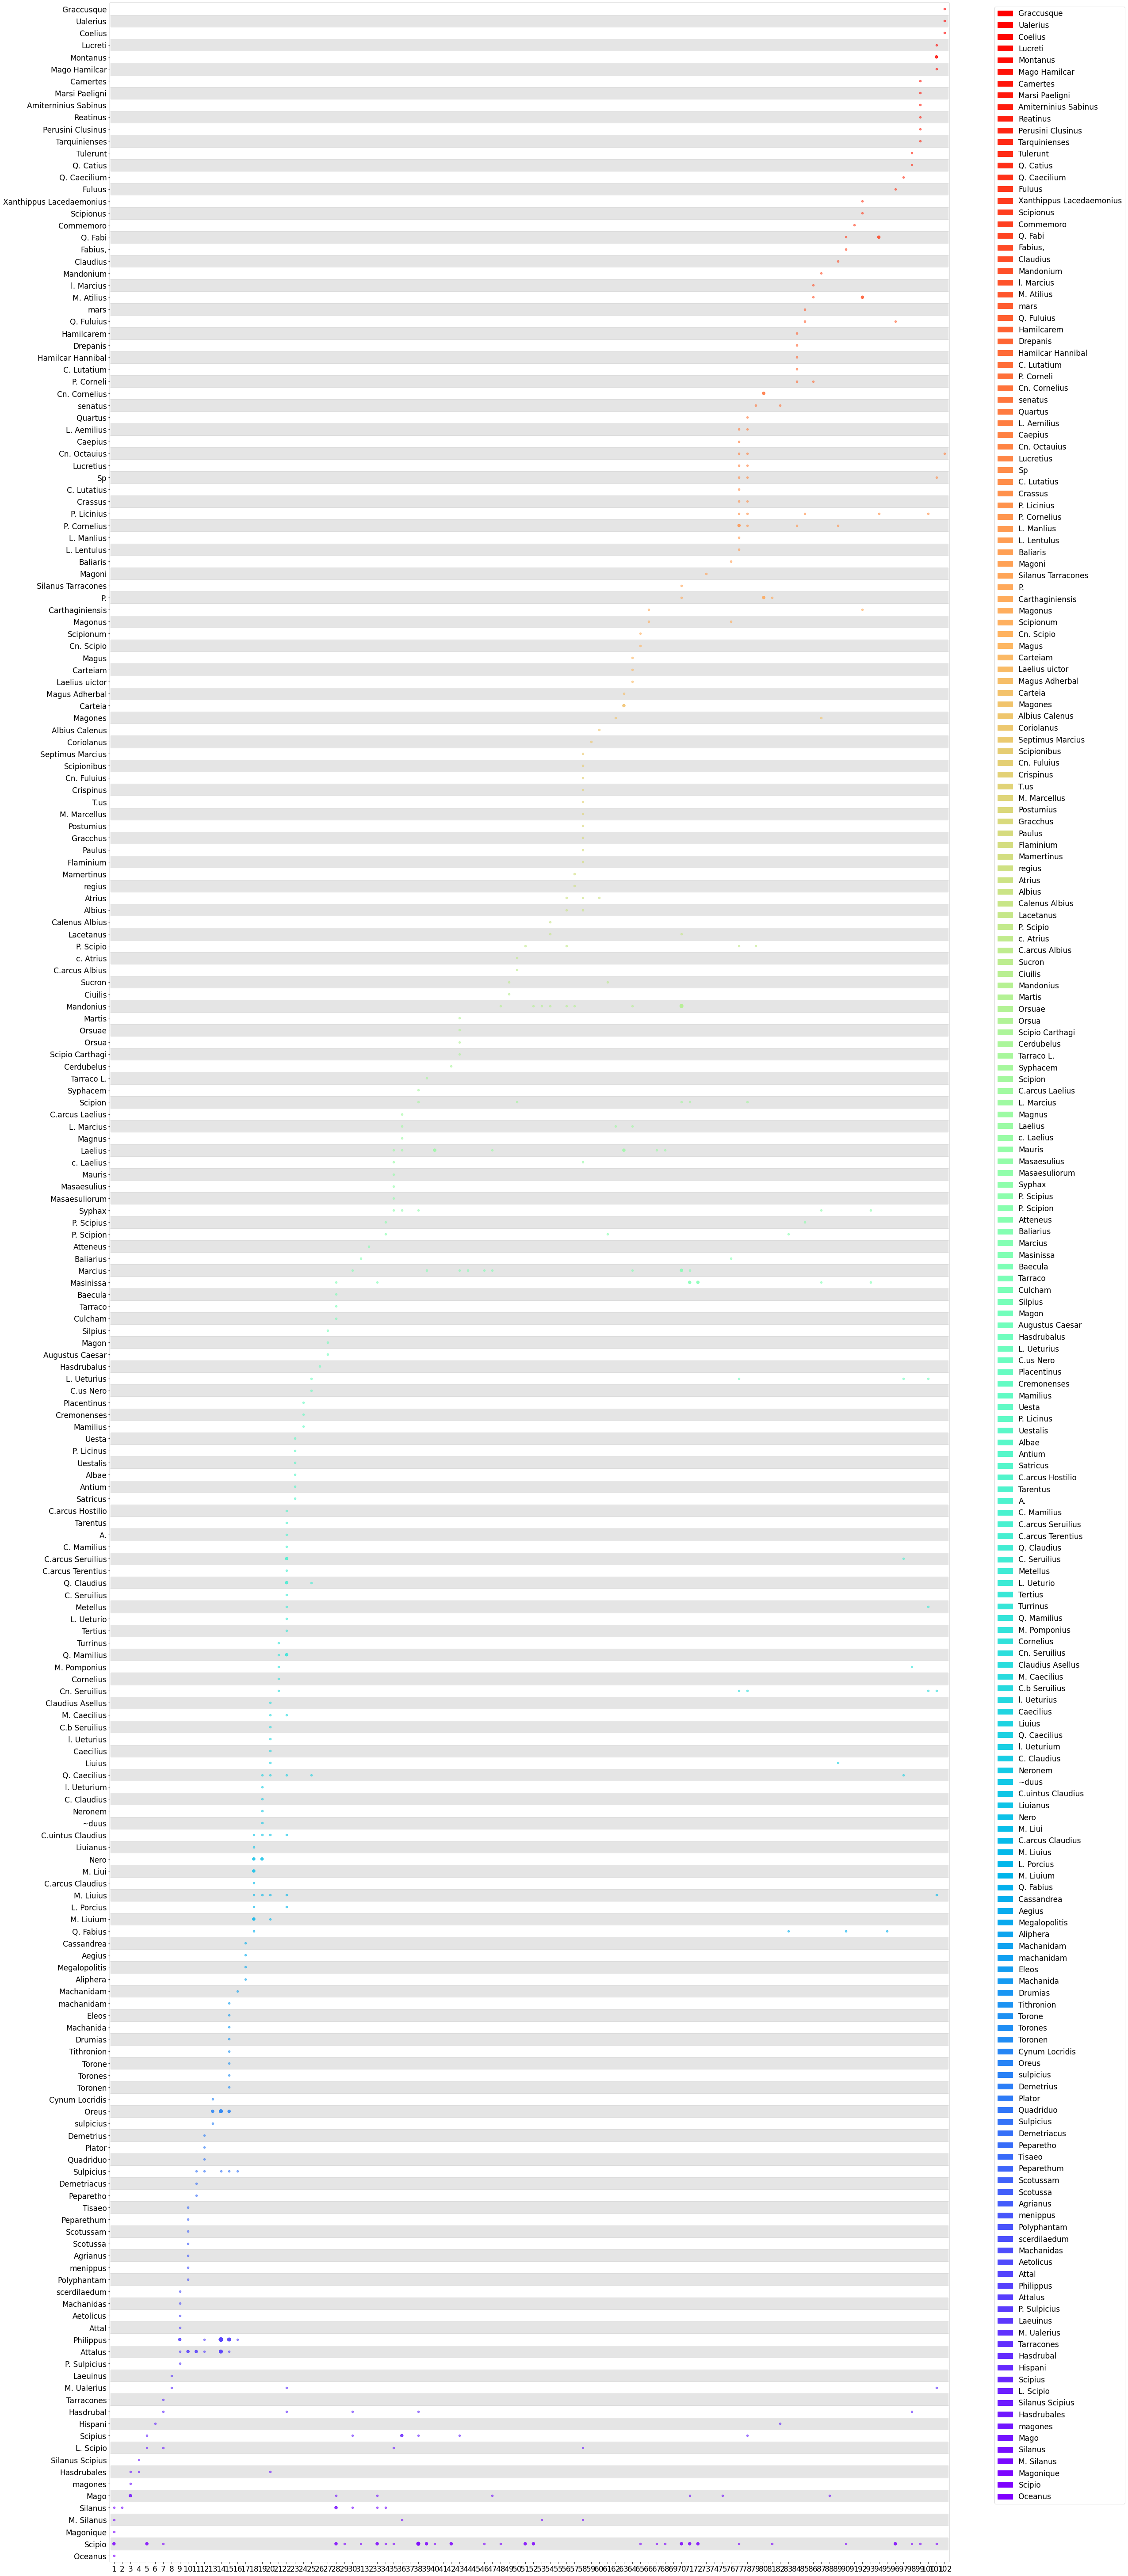

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define the figure size
fig, ax = plt.subplots(figsize=(len(chapters)/3, len(people)/2))

# Set the global font size
plt.rcParams.update({'font.size': 17})

# Get a list of unique entities and create a color for each entity
entities = list(person_mention_positions.keys())
num_entities = len(entities)
colors = plt.cm.rainbow(np.linspace(0, 1, num_entities))

# Create a numeric representation of the chapters
c = {i: i for i in range(1, len(chapters)+1)}


# Add alternating background colors
for i in range(1, num_entities+1):
    if i % 2 == 0:
        ax.fill_betweenx(y=[i-0.5, i+0.5], x1=0.5, x2=max(c.values())+0.5, color='gray', alpha=0.2)

# For holding patches for creating custom legend
patches = []

for color, (entity, entity_chapters) in zip(colors, person_mention_positions.items()):
    for chapter, positions in entity_chapters.items():
        y = [entities.index(entity)+1] * len(positions) # start y-axis at 1
        x = [c[chapter]] * len(positions)
        size = [20 * len(positions) for _ in positions]
        ax.scatter(x, y, s=size, color=color, alpha=0.6)
    
    # Create patch for each entity
    patches.append(mpatches.Patch(color=color, label=entity))

# Set the y-ticks and y-ticklabels to the entity names
ax.set_yticks(range(1, num_entities+1))
ax.set_yticklabels(entities)

# Set the x-ticks and x-ticklabels to the chapter numbers
ax.set_xticks(range(1, max(c.values())+1))
ax.set_xticklabels(range(1, max(c.values())+1))

# Set the x-limits and y-limits of the plot
ax.set_xlim([0.5, max(c.values())+0.5]) # start x-axis at 1
ax.set_ylim([0.5, num_entities+0.5]) # start y-axis at 1

# Add custom legend outside the plot at the right side
plt.legend(handles=patches[::-1], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
